In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from numpy.polynomial import hermite
from scipy.interpolate import CubicHermiteSpline

import warnings
warnings.filterwarnings("ignore")

eps = 1e-13

In [2]:
du = lambda x, u, h, k: h * u + k * np.cos(k * x) - h * np.sin(k * x)
u = lambda x, C, h, k: C * np.exp(h * x) + np.sin(k * x)

$$ h = 1, k = 0.5 $$
$$ u' = f(x, u) = -u + cos(x) + sin(x) $$
$$ u(x_0) = y_0 $$
$$ u_{i} = y_0 + \int_{x_0}^x f(x, u_{i-1}) dx $$


In [3]:
h = 1e-3
x_grid = np.arange(0, 40 + h, h)

In [4]:
def GetY_x1(f, x_0, x_1, y_0, h):
    y_i_1 = y_0
    y_i_1_next = y_0 + 1
    f_x_0 = f(x_0, y_0)
    while abs(y_i_1_next - y_i_1) > eps:
        y_i_1 = y_i_1_next
        f_x_1 = f(x_1, y_i_1)
        y_i_1_next = y_0 + h / 2 * (f_x_0 + f_x_1)
    return y_i_1_next

def NumericalODEwithStaticStep(f, x_0, y_0, b, h, flag=False):
    # solve in [x_0, b]
    x_grid = np.arange(x_0, b + h, h)
    y_i = [y_0, GetY_x1(f, x_grid[0], x_grid[1], y_0, h) if flag else np.sin(x_grid[1] / 2)]
    f_values = [f(x_grid[0], y_i[0]), f(x_grid[1], y_i[1]), 0]
    
    for i in range(2, len(x_grid)):
        y_x_i = y_i[-1]
        y_x_i_next = y_i[-1] + 1
        while abs(y_x_i_next - y_x_i) > eps:
            y_x_i = y_x_i_next
            f_values[2] = f(x_grid[i], y_x_i)
            y_x_i_next = y_i[-2] + h / 3 * (f_values[0] + 4 * f_values[1] + f_values[2]) 
            
        f_values[:2] = f_values[1:]
        y_i.append(y_x_i_next)

    return y_i

In [5]:
y_grid_analytical_x1 = NumericalODEwithStaticStep(lambda x, y: du(x, y, 1, 0.5),
                                          0, 0, 40, h, True)
y_grid_numerical_x1 = NumericalODEwithStaticStep(lambda x, y: du(x, y, 1, 0.5),
                                         0, 0, 40, h, False)

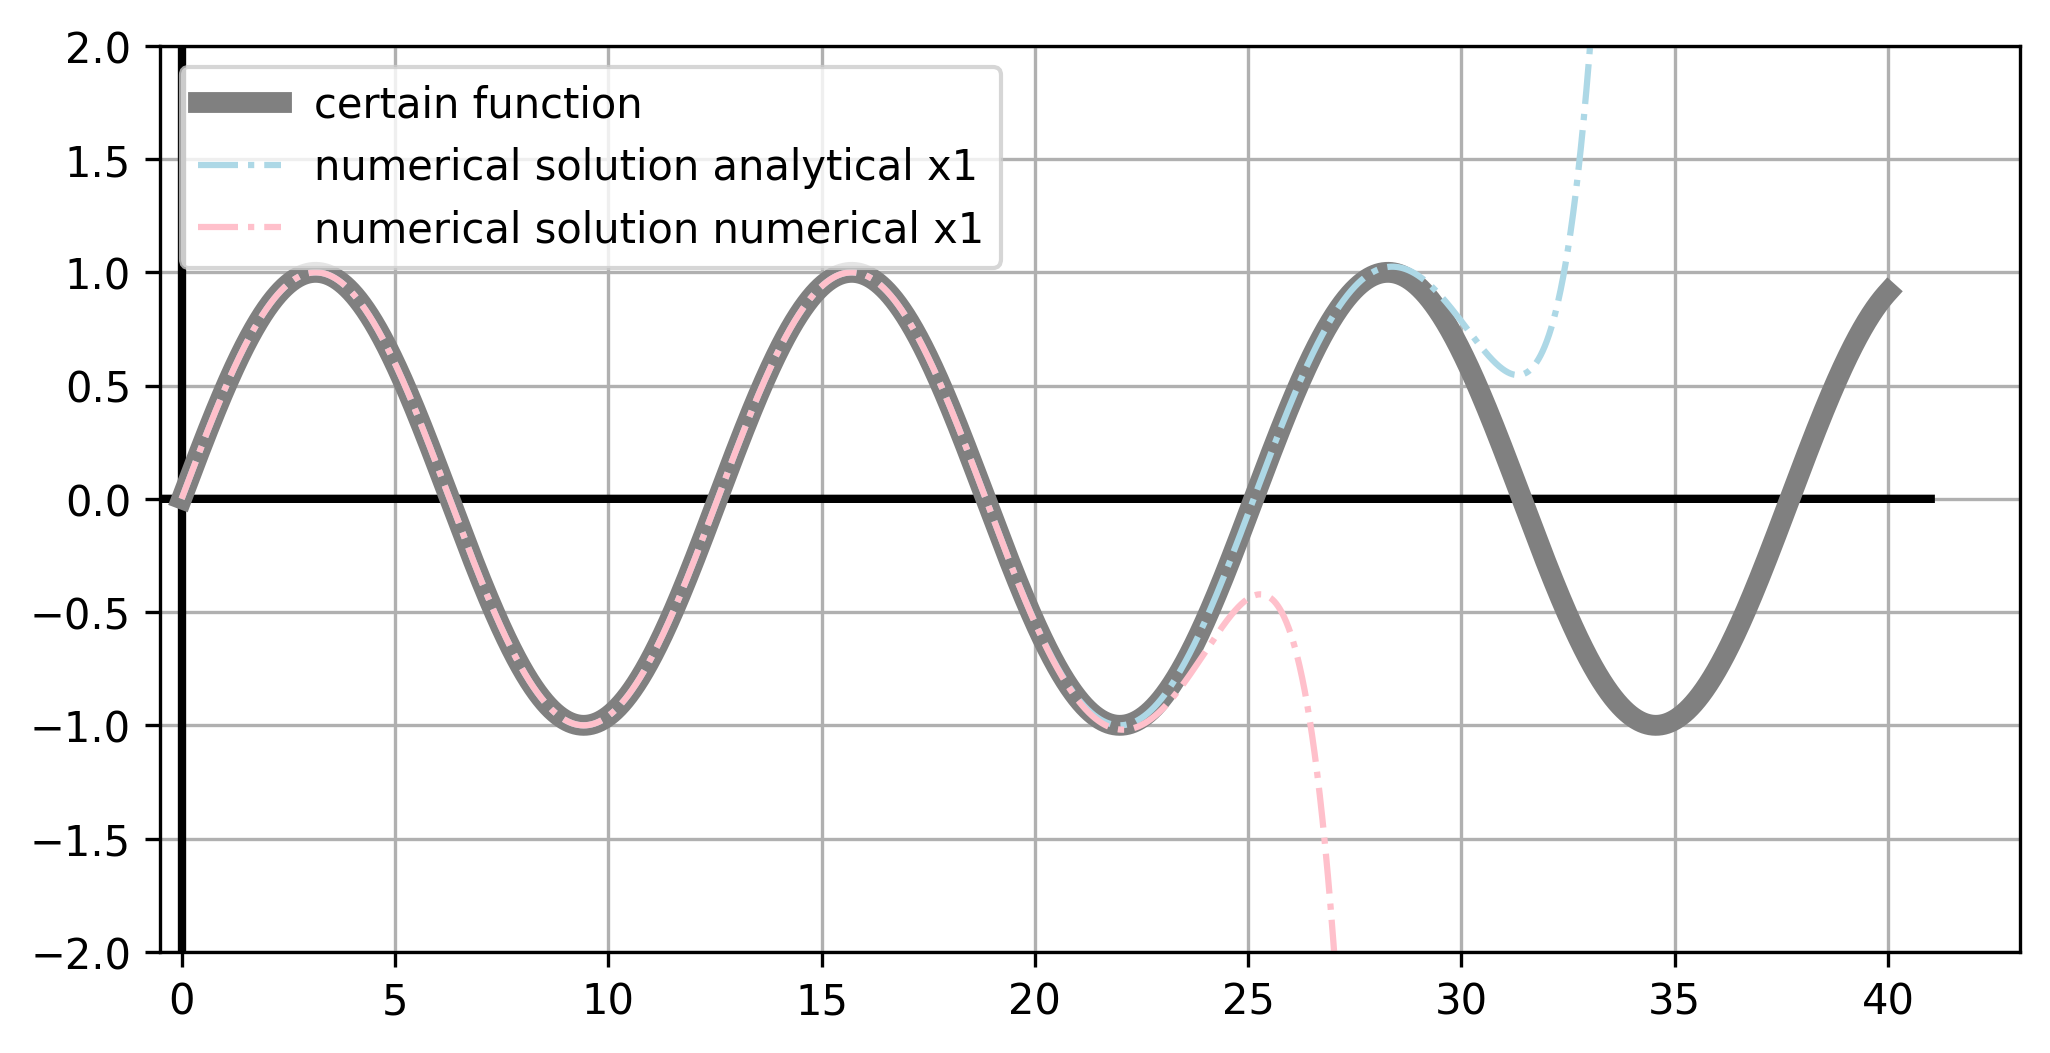

In [6]:
plt.figure(figsize=(8, 4), dpi=300)
plt.grid()
plt.plot(x_grid * 1.05 - 1, np.zeros(len(x_grid)), 'black', linewidth=2)
plt.plot([0, 1e-15], [-2, 2], 'black', linewidth=2)
plt.ylim(-2, 2)
plt.xlim(-0.5)

plt.plot(x_grid, [u(x, 0, 1, 0.5) for x in x_grid],
         'gray', label='certain function', linewidth = 5)
plt.plot(x_grid, y_grid_numerical_x1,
         'lightblue', label='numerical solution analytical x1', linestyle='-.')
plt.plot(x_grid, y_grid_analytical_x1,
         'pink', label='numerical solution numerical x1', linestyle='-.')
plt.legend()
plt.show()

In [7]:
solution = lambda x: u(x, 0, 1, 0.5)

def IntegrateSimpsonBy3(f, x, y):
    f_values = f(np.array(x), np.array(y))
    f_values[1] *= 4
    step = x[1] - x[0]
    
    while True:
        temp = y[2]
        f_values[2] = f(x[2], y[2])
        y[2] = y[0] + step / 3 * np.sum(f_values)
        if abs(temp - y[2]) < eps * abs(y[2]):
            break
    
    return y[2]

def GetX(x10, step):
    return x10 + np.linspace(-step, step, 5)

def NumericalODEwithDynamicStep(f, x_0, y_0, b, initial_step=0.1,
                                lower_bound_step=1e-2, freq_inc=7):
    # solve in [x_0, b]
    step = initial_step
    x00, x05, x10, x15, x20 = GetX(x_0 + step, step)
    
    y00 = y_0
    y05 = solution(x05)
    y10 = solution(x10)
    
    x_grid = [x00, x05, x10]
    y_grid = [y00, y05, y10]
    f_grid = [f(x00, y00), f(x05, y05), f(x10, y10)]
    
    count_without_less = 0
    while True:
        poly = CubicHermiteSpline(x_grid, y_grid, f_grid)
        while True:
            y15 = poly(x15)
            y20 = poly(x20)

            y15 = IntegrateSimpsonBy3(f, [x05, x10, x15], [y05, y10, y15])

            y20_v1 = IntegrateSimpsonBy3(f, [x00, x10, x20], [y00, y10, y20])
            y20_v2 = IntegrateSimpsonBy3(f, [x10, x15, x20], [y10, y15, y20])
            
            delta = (y20_v2 - y20_v1) * 32 / 31
            y20 = y20_v1 + delta
        
            if abs(delta) < eps * abs(y20) or step < lower_bound_step:
                count_without_less += 1
                break
            else:
                step /= 2
                count_without_less = 0
                x00, x05, x10, x15, x20 = GetX(x10, step)
                y00 = y05
                y05 = poly(x05)

        x_grid.append(x20)
        y_grid.append(y20)
        f_grid.append(f(x20, y20))

        if x20 >= b or abs(y20) >= 2:
            return np.array(x_grid), np.array(y_grid)
        
        if count_without_less > freq_inc:
            count_without_less = 0
            step *= 2
            x00, x05, x10, x15, x20 = GetX(x20, step)
            y00, y05, y10 = y00, y10, y20
        else:
            x00, x05, x10, x15, x20 = GetX(x20, step)
            y00, y05, y10 = y10, y15, y20

y = NumericalODEwithDynamicStep(lambda x, y: du(x, y, 1, 0.5), 0, 0, 40)

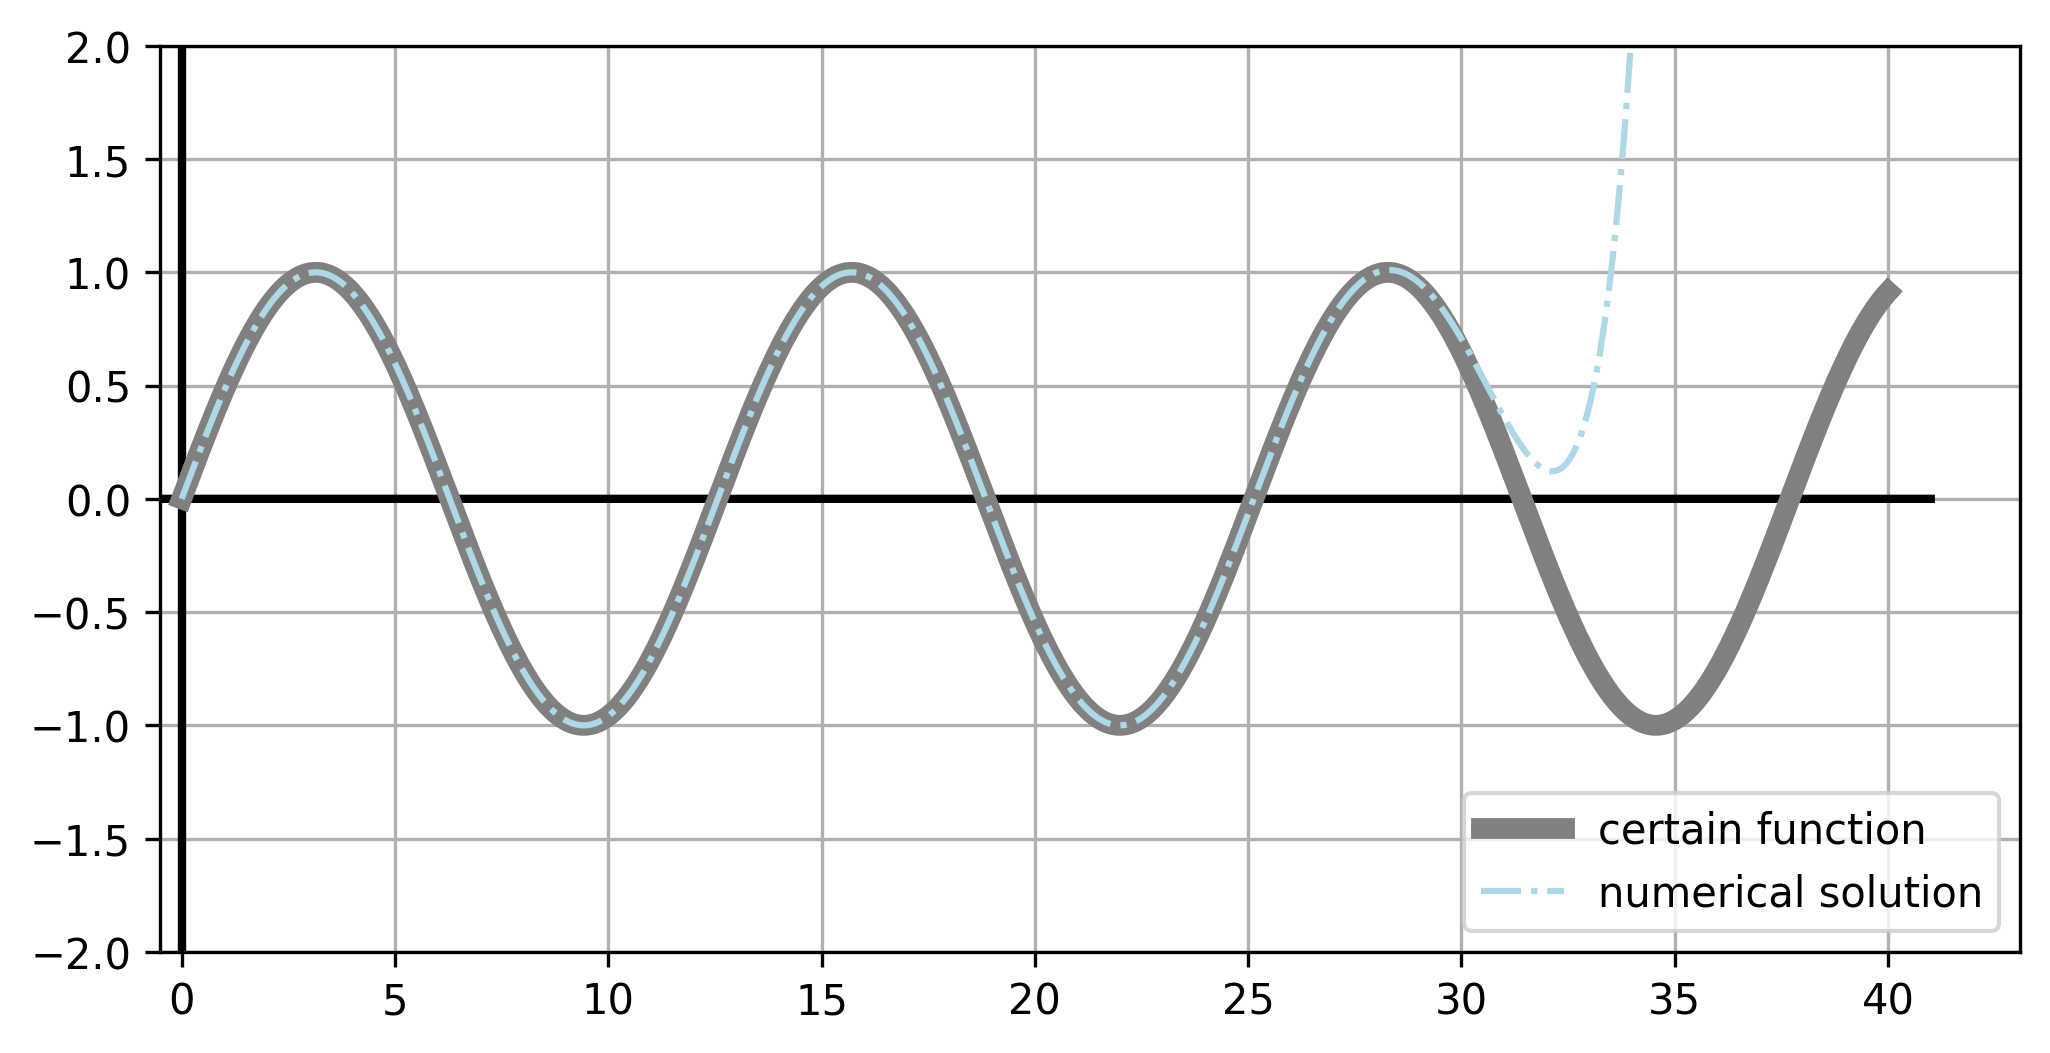

In [8]:
plt.figure(figsize=(8, 4), dpi=300)
plt.grid()
plt.plot(x_grid * 1.05 - 1, np.zeros(len(x_grid)), 'black', linewidth=2)
plt.plot([0, 1e-15], [-2, 2], 'black', linewidth=2)
plt.ylim(-2, 2)
plt.xlim(-0.5)
plt.plot(x_grid, [u(x, 0, 1, 0.5) for x in x_grid],
         'gray', label='certain function', linewidth = 5)
plt.plot(*y,
         'lightblue', label='numerical solution', linestyle='-.')

plt.legend()
plt.show()

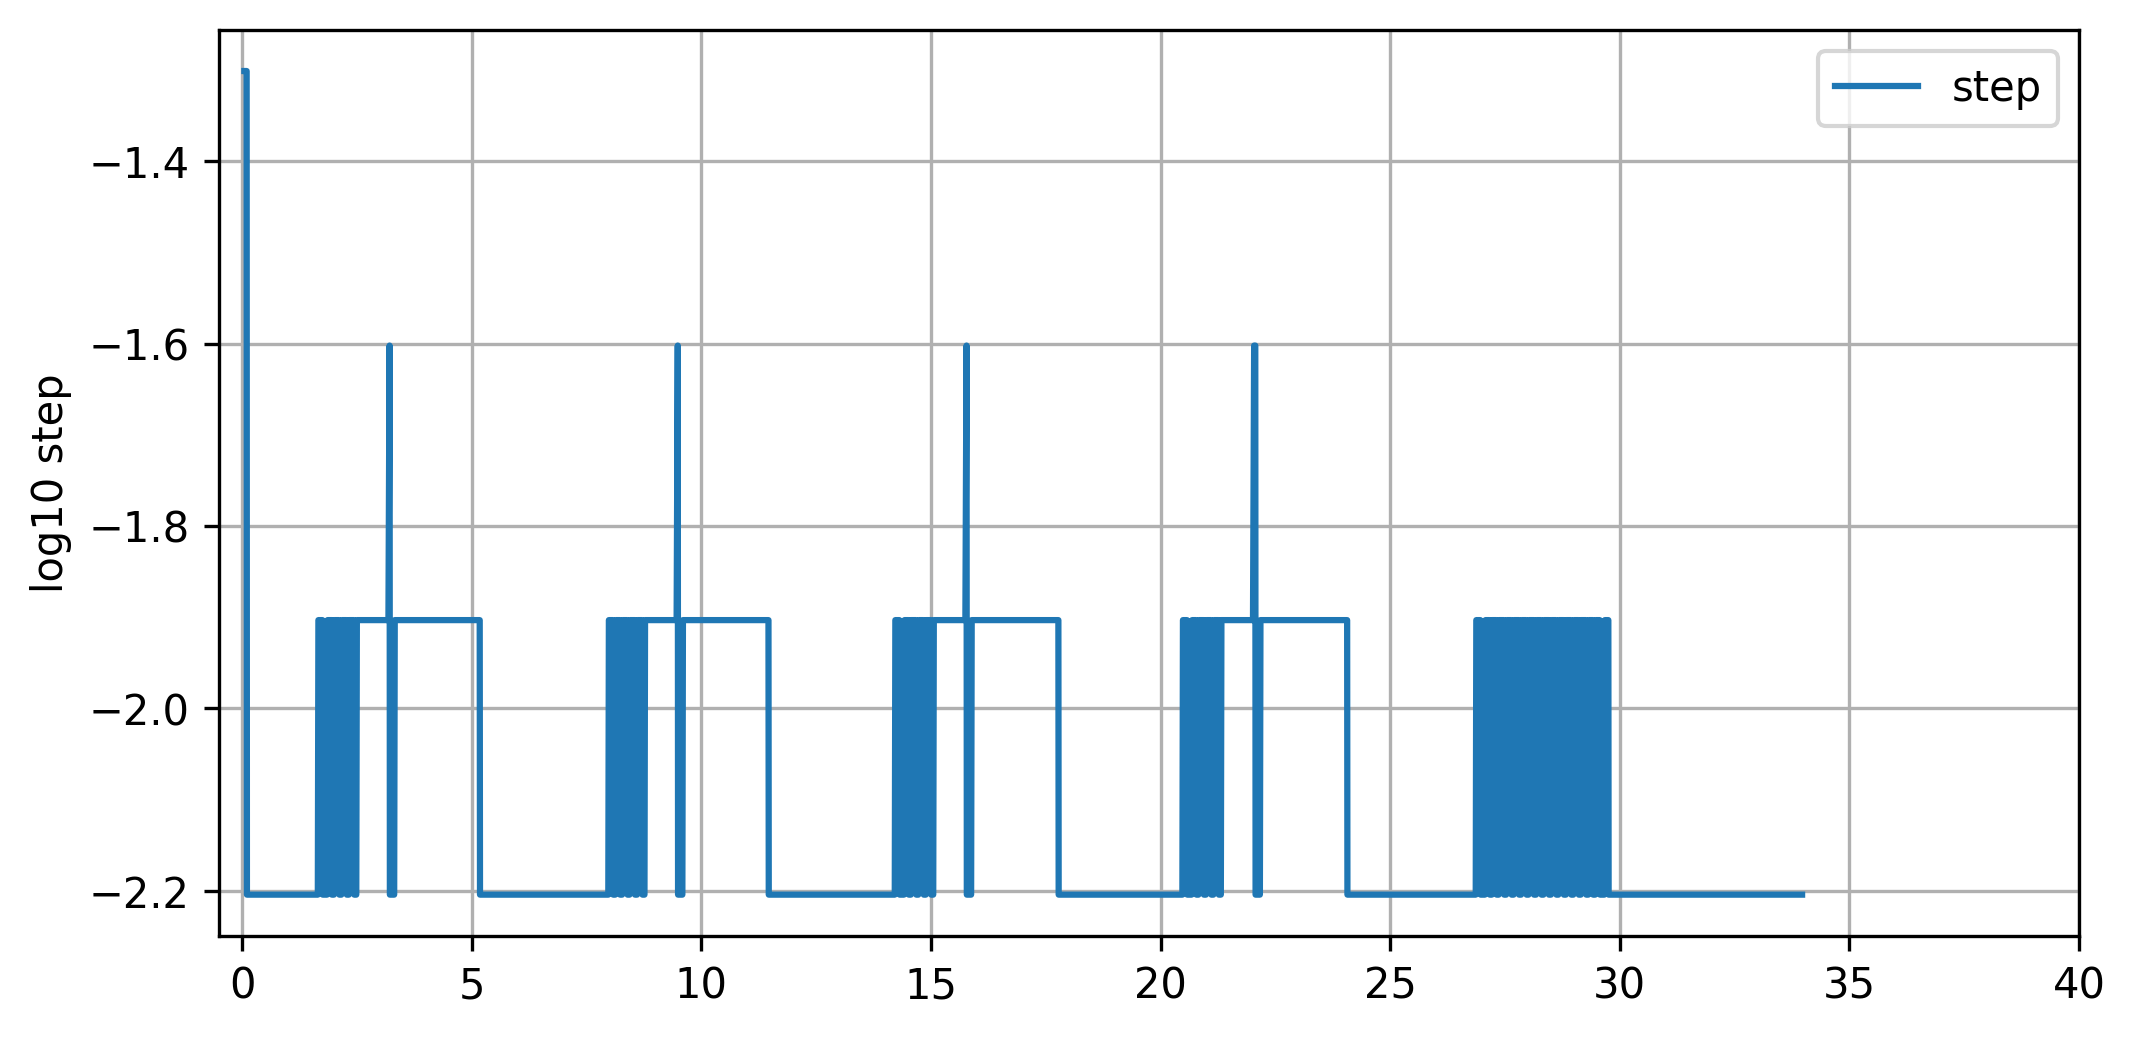

In [9]:
plt.figure(figsize=(8, 4), dpi=300)
plt.grid()
plt.xlim(-0.5, 40)
plt.plot(y[0][1:], np.log10(y[0][1:] - y[0][:-1]), label='step')
plt.legend()
plt.ylabel('log10 step')
plt.show()